# Sequential Gaussian simulation

We saw in the kriging example that kriging does not reproduce the variogram statistics of the data, making it an unrealistically smooth representation of geologically phenomena. To reproduce the variogram statistics, we perform sequential Gaussian simulation, a common method for stochastic simulation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer 
import gstatsim as gs
import skgstat as skg
from skgstat import models
import random

# plotting utility functions
from plot_utils import splot2D, mplot1, make_colorbar

## Load and plot data

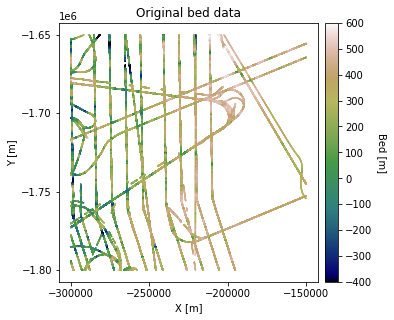

In [2]:
df_bed = pd.read_csv('data/greenland_test_data.csv')

# remove erroneously high values due to bad bed picks
df_bed = df_bed[df_bed["Bed"] <= 700]  

# plot original data
splot2D(df=df_bed, title='Original bed data')

## Grid and transform data, compute variogram parameters

In [3]:
# grid data to 100 m resolution and remove coordinates with NaNs
res = 1000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Bed"})

# normal score transformation
data = df_grid['Bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
df_grid['Nbed'] = nst_trans.transform(data) 

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000             # maximum range distance
n_lags = 70                # num of bins

V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, 
                   maxlag=maxlag, normalize=False)

# use exponential variogram model
V1.model = 'exponential'

## Initialize grid

Make list of grid cells that need to be simulated.

In [4]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Sequential Gaussian simulation

Sequential Gaussian simulation (SGS) uses kriging to sequentially estimate the kriging mean and variance at each grid cell. This mean and variance define a Gaussian probability distribution from which a random value sampled in order to simulate a grid cell.

:::{figure-md} markdown-fig
<img src="./Images/SGS_cartoon-01.jpg" class="bg-primary mb-1" width="700px">

Sequential Gaussian simulation
:::

We have two versions of sequential Gaussian simulation, skrige_sgs and okrige_sgs, which use simple and ordinary kriging, respectively. In this example we use okrige_sgs.

In [5]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill]

k = 48         # number of neighboring data points used to estimate a given point 
rad = 50000    # 50 km search radius

sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 

  0%|                                                 | 0/22500 [00:00<?, ?it/s]

  0%|                                       | 14/22500 [00:00<02:44, 136.85it/s]

  0%|                                       | 34/22500 [00:00<02:11, 170.28it/s]

  0%|                                       | 52/22500 [00:00<02:17, 163.32it/s]

  0%|                                       | 70/22500 [00:00<02:15, 165.54it/s]

  0%|▏                                      | 87/22500 [00:00<02:14, 166.12it/s]

  0%|▏                                     | 106/22500 [00:00<02:10, 170.96it/s]

  1%|▏                                     | 124/22500 [00:00<02:10, 171.16it/s]

  1%|▏                                     | 143/22500 [00:00<02:08, 173.79it/s]

  1%|▎                                     | 161/22500 [00:00<02:11, 170.32it/s]

  1%|▎                                     | 181/22500 [00:01<02:05, 177.77it/s]

  1%|▎                                     | 201/22500 [00:01<02:02, 181.74it/s]

  1%|▎                                     | 220/22500 [00:01<02:06, 176.64it/s]

  1%|▍                                     | 238/22500 [00:01<02:06, 176.34it/s]

  1%|▍                                     | 256/22500 [00:01<02:09, 172.27it/s]

  1%|▍                                     | 277/22500 [00:01<02:03, 180.46it/s]

  1%|▍                                     | 296/22500 [00:01<02:05, 177.17it/s]

  1%|▌                                     | 316/22500 [00:01<02:02, 181.32it/s]

  1%|▌                                     | 335/22500 [00:01<02:03, 179.31it/s]

  2%|▌                                     | 353/22500 [00:02<02:04, 177.52it/s]

  2%|▋                                     | 371/22500 [00:02<02:07, 173.00it/s]

  2%|▋                                     | 389/22500 [00:02<02:07, 173.48it/s]

  2%|▋                                     | 407/22500 [00:02<02:05, 175.34it/s]

  2%|▋                                     | 427/22500 [00:02<02:02, 179.66it/s]

  2%|▊                                     | 445/22500 [00:02<02:05, 175.67it/s]

  2%|▊                                     | 463/22500 [00:02<02:07, 173.34it/s]

  2%|▊                                     | 481/22500 [00:02<02:07, 172.71it/s]

  2%|▊                                     | 499/22500 [00:02<02:12, 166.59it/s]

  2%|▊                                     | 516/22500 [00:02<02:14, 163.52it/s]

  2%|▉                                     | 534/22500 [00:03<02:11, 166.41it/s]

  2%|▉                                     | 551/22500 [00:03<02:14, 162.66it/s]

  3%|▉                                     | 568/22500 [00:03<02:14, 162.94it/s]

  3%|▉                                     | 585/22500 [00:03<02:15, 161.16it/s]

  3%|█                                     | 603/22500 [00:03<02:12, 164.89it/s]

  3%|█                                     | 622/22500 [00:03<02:07, 171.85it/s]

  3%|█                                     | 643/22500 [00:03<01:59, 182.46it/s]

  3%|█                                     | 662/22500 [00:03<01:59, 182.02it/s]

  3%|█▏                                    | 681/22500 [00:03<02:06, 173.17it/s]

  3%|█▏                                    | 700/22500 [00:04<02:03, 176.45it/s]

  3%|█▏                                    | 719/22500 [00:04<02:00, 180.26it/s]

  3%|█▏                                    | 738/22500 [00:04<02:00, 180.80it/s]

  3%|█▎                                    | 758/22500 [00:04<01:58, 183.52it/s]

  3%|█▎                                    | 780/22500 [00:04<01:52, 193.09it/s]

  4%|█▎                                    | 800/22500 [00:04<01:57, 185.10it/s]

  4%|█▍                                    | 819/22500 [00:04<01:57, 184.90it/s]

  4%|█▍                                    | 838/22500 [00:04<01:57, 183.84it/s]

  4%|█▍                                    | 857/22500 [00:04<01:56, 185.47it/s]

  4%|█▍                                    | 877/22500 [00:04<01:54, 189.35it/s]

  4%|█▌                                    | 897/22500 [00:05<01:54, 189.35it/s]

  4%|█▌                                    | 916/22500 [00:05<01:58, 181.53it/s]

  4%|█▌                                    | 935/22500 [00:05<02:02, 176.40it/s]

  4%|█▌                                    | 953/22500 [00:05<02:05, 172.00it/s]

  4%|█▋                                    | 971/22500 [00:05<02:05, 172.07it/s]

  4%|█▋                                    | 990/22500 [00:05<02:04, 172.77it/s]

  4%|█▋                                   | 1008/22500 [00:05<02:06, 170.24it/s]

  5%|█▋                                   | 1026/22500 [00:05<02:08, 167.02it/s]

  5%|█▋                                   | 1046/22500 [00:05<02:03, 174.09it/s]

  5%|█▋                                   | 1064/22500 [00:06<02:02, 175.16it/s]

  5%|█▊                                   | 1084/22500 [00:06<01:58, 180.87it/s]

  5%|█▊                                   | 1103/22500 [00:06<01:57, 182.41it/s]

  5%|█▊                                   | 1122/22500 [00:06<01:58, 180.20it/s]

  5%|█▉                                   | 1141/22500 [00:06<02:06, 168.94it/s]

  5%|█▉                                   | 1159/22500 [00:06<02:07, 167.15it/s]

  5%|█▉                                   | 1180/22500 [00:06<01:59, 178.37it/s]

  5%|█▉                                   | 1198/22500 [00:06<02:00, 176.06it/s]

  5%|█▉                                   | 1216/22500 [00:06<02:01, 174.99it/s]

  5%|██                                   | 1234/22500 [00:07<02:00, 175.85it/s]

  6%|██                                   | 1254/22500 [00:07<01:57, 181.43it/s]

  6%|██                                   | 1274/22500 [00:07<01:55, 184.01it/s]

  6%|██▏                                  | 1293/22500 [00:07<02:00, 176.38it/s]

  6%|██▏                                  | 1311/22500 [00:07<02:04, 170.22it/s]

  6%|██▏                                  | 1329/22500 [00:07<02:02, 172.52it/s]

  6%|██▏                                  | 1347/22500 [00:07<02:04, 170.38it/s]

  6%|██▏                                  | 1365/22500 [00:07<02:05, 168.94it/s]

  6%|██▎                                  | 1382/22500 [00:07<02:07, 165.37it/s]

  6%|██▎                                  | 1400/22500 [00:08<02:04, 169.30it/s]

  6%|██▎                                  | 1419/22500 [00:08<02:02, 172.75it/s]

  6%|██▎                                  | 1440/22500 [00:08<01:55, 182.37it/s]

  6%|██▍                                  | 1459/22500 [00:08<01:54, 184.48it/s]

  7%|██▍                                  | 1478/22500 [00:08<01:56, 181.14it/s]

  7%|██▍                                  | 1497/22500 [00:08<01:56, 180.29it/s]

  7%|██▍                                  | 1516/22500 [00:08<02:00, 173.45it/s]

  7%|██▌                                  | 1535/22500 [00:08<01:57, 177.90it/s]

  7%|██▌                                  | 1553/22500 [00:08<01:59, 175.46it/s]

  7%|██▌                                  | 1571/22500 [00:08<02:01, 172.71it/s]

  7%|██▌                                  | 1589/22500 [00:09<02:02, 170.01it/s]

  7%|██▋                                  | 1607/22500 [00:09<02:04, 168.16it/s]

  7%|██▋                                  | 1625/22500 [00:09<02:02, 171.09it/s]

  7%|██▋                                  | 1644/22500 [00:09<01:58, 176.16it/s]

  7%|██▋                                  | 1663/22500 [00:09<01:57, 177.43it/s]

  7%|██▊                                  | 1682/22500 [00:09<01:56, 178.40it/s]

  8%|██▊                                  | 1700/22500 [00:09<01:59, 173.37it/s]

  8%|██▊                                  | 1720/22500 [00:09<01:55, 180.36it/s]

  8%|██▊                                  | 1739/22500 [00:09<01:57, 177.22it/s]

  8%|██▉                                  | 1758/22500 [00:10<01:56, 177.98it/s]

  8%|██▉                                  | 1776/22500 [00:10<01:56, 178.42it/s]

  8%|██▉                                  | 1794/22500 [00:10<01:56, 178.47it/s]

  8%|██▉                                  | 1812/22500 [00:10<01:56, 178.11it/s]

  8%|███                                  | 1832/22500 [00:10<01:52, 184.30it/s]

  8%|███                                  | 1851/22500 [00:10<01:56, 177.12it/s]

  8%|███                                  | 1869/22500 [00:10<01:58, 174.67it/s]

  8%|███                                  | 1887/22500 [00:10<01:57, 175.49it/s]

  8%|███▏                                 | 1907/22500 [00:10<01:54, 179.46it/s]

  9%|███▏                                 | 1926/22500 [00:10<01:54, 179.27it/s]

  9%|███▏                                 | 1944/22500 [00:11<01:56, 176.63it/s]

  9%|███▏                                 | 1964/22500 [00:11<01:52, 182.43it/s]

  9%|███▎                                 | 1983/22500 [00:11<01:51, 183.32it/s]

  9%|███▎                                 | 2002/22500 [00:11<01:54, 179.05it/s]

  9%|███▎                                 | 2020/22500 [00:11<01:55, 177.87it/s]

  9%|███▎                                 | 2040/22500 [00:11<01:51, 183.98it/s]

  9%|███▍                                 | 2059/22500 [00:11<01:52, 181.96it/s]

  9%|███▍                                 | 2078/22500 [00:11<01:57, 173.61it/s]

  9%|███▍                                 | 2096/22500 [00:11<02:00, 168.97it/s]

  9%|███▍                                 | 2115/22500 [00:12<01:57, 174.20it/s]

  9%|███▌                                 | 2133/22500 [00:12<02:00, 169.53it/s]

 10%|███▌                                 | 2152/22500 [00:12<01:58, 172.44it/s]

 10%|███▌                                 | 2170/22500 [00:12<01:58, 171.06it/s]

 10%|███▌                                 | 2188/22500 [00:12<01:59, 169.48it/s]

 10%|███▋                                 | 2206/22500 [00:12<01:59, 169.67it/s]

 10%|███▋                                 | 2223/22500 [00:12<02:00, 168.93it/s]

 10%|███▋                                 | 2242/22500 [00:12<01:55, 174.83it/s]

 10%|███▋                                 | 2265/22500 [00:12<01:47, 187.40it/s]

 10%|███▊                                 | 2284/22500 [00:12<01:50, 183.50it/s]

 10%|███▊                                 | 2303/22500 [00:13<01:52, 179.09it/s]

 10%|███▊                                 | 2321/22500 [00:13<01:55, 174.94it/s]

 10%|███▊                                 | 2339/22500 [00:13<01:58, 170.05it/s]

 10%|███▉                                 | 2358/22500 [00:13<01:56, 172.84it/s]

 11%|███▉                                 | 2376/22500 [00:13<01:55, 174.68it/s]

 11%|███▉                                 | 2395/22500 [00:13<01:52, 178.18it/s]

 11%|███▉                                 | 2413/22500 [00:13<01:53, 177.02it/s]

 11%|███▉                                 | 2431/22500 [00:13<01:53, 177.59it/s]

 11%|████                                 | 2449/22500 [00:13<01:53, 177.12it/s]

 11%|████                                 | 2470/22500 [00:14<01:49, 183.40it/s]

 11%|████                                 | 2489/22500 [00:14<01:51, 179.91it/s]

 11%|████                                 | 2508/22500 [00:14<01:53, 176.17it/s]

 11%|████▏                                | 2526/22500 [00:14<01:52, 177.05it/s]

 11%|████▏                                | 2546/22500 [00:14<01:49, 182.51it/s]

 11%|████▏                                | 2565/22500 [00:14<01:53, 175.53it/s]

 11%|████▏                                | 2583/22500 [00:14<01:53, 175.67it/s]

 12%|████▎                                | 2602/22500 [00:14<01:52, 176.33it/s]

 12%|████▎                                | 2620/22500 [00:14<01:54, 173.94it/s]

 12%|████▎                                | 2638/22500 [00:15<01:55, 172.30it/s]

 12%|████▎                                | 2656/22500 [00:15<01:55, 171.49it/s]

 12%|████▍                                | 2674/22500 [00:15<01:54, 172.98it/s]

 12%|████▍                                | 2692/22500 [00:15<01:56, 169.32it/s]

 12%|████▍                                | 2709/22500 [00:15<01:59, 166.23it/s]

 12%|████▍                                | 2726/22500 [00:15<01:58, 166.32it/s]

 12%|████▌                                | 2743/22500 [00:15<01:59, 164.70it/s]

 12%|████▌                                | 2760/22500 [00:15<02:00, 163.35it/s]

 12%|████▌                                | 2778/22500 [00:15<01:59, 165.05it/s]

 12%|████▌                                | 2795/22500 [00:15<02:02, 160.66it/s]

 12%|████▌                                | 2812/22500 [00:16<02:01, 162.59it/s]

 13%|████▋                                | 2833/22500 [00:16<01:53, 173.81it/s]

 13%|████▋                                | 2851/22500 [00:16<01:54, 172.25it/s]

 13%|████▋                                | 2869/22500 [00:16<01:53, 173.60it/s]

 13%|████▊                                | 2891/22500 [00:16<01:45, 185.05it/s]

 13%|████▊                                | 2910/22500 [00:16<01:50, 177.98it/s]

 13%|████▊                                | 2928/22500 [00:16<01:53, 172.78it/s]

 13%|████▊                                | 2946/22500 [00:16<01:55, 169.24it/s]

 13%|████▊                                | 2964/22500 [00:16<01:54, 170.66it/s]

 13%|████▉                                | 2983/22500 [00:17<01:52, 173.88it/s]

 13%|████▉                                | 3001/22500 [00:17<01:52, 173.91it/s]

 13%|████▉                                | 3019/22500 [00:17<01:56, 166.64it/s]

 13%|████▉                                | 3037/22500 [00:17<01:54, 170.15it/s]

 14%|█████                                | 3055/22500 [00:17<01:58, 163.64it/s]

 14%|█████                                | 3072/22500 [00:17<02:00, 161.20it/s]

 14%|█████                                | 3089/22500 [00:17<02:01, 160.18it/s]

 14%|█████                                | 3110/22500 [00:17<01:53, 170.92it/s]

 14%|█████▏                               | 3128/22500 [00:17<01:54, 169.07it/s]

 14%|█████▏                               | 3145/22500 [00:18<01:57, 165.19it/s]

 14%|█████▏                               | 3162/22500 [00:18<01:59, 161.51it/s]

 14%|█████▏                               | 3180/22500 [00:18<01:56, 165.98it/s]

 14%|█████▎                               | 3197/22500 [00:18<02:10, 148.01it/s]

 14%|█████▎                               | 3214/22500 [00:18<02:07, 151.74it/s]

 14%|█████▎                               | 3231/22500 [00:18<02:04, 155.21it/s]

 14%|█████▎                               | 3249/22500 [00:18<01:59, 161.36it/s]

 15%|█████▍                               | 3270/22500 [00:18<01:51, 172.82it/s]

 15%|█████▍                               | 3288/22500 [00:18<01:51, 172.69it/s]

 15%|█████▍                               | 3306/22500 [00:19<01:52, 170.35it/s]

 15%|█████▍                               | 3324/22500 [00:19<01:53, 168.60it/s]

 15%|█████▍                               | 3342/22500 [00:19<01:51, 171.24it/s]

 15%|█████▌                               | 3360/22500 [00:19<01:53, 168.86it/s]

 15%|█████▌                               | 3379/22500 [00:19<01:50, 172.39it/s]

 15%|█████▌                               | 3398/22500 [00:19<01:49, 175.09it/s]

 15%|█████▌                               | 3416/22500 [00:19<01:51, 170.68it/s]

 15%|█████▋                               | 3434/22500 [00:19<01:51, 171.48it/s]

 15%|█████▋                               | 3452/22500 [00:19<01:50, 172.21it/s]

 15%|█████▋                               | 3470/22500 [00:19<01:51, 170.25it/s]

 16%|█████▋                               | 3488/22500 [00:20<01:50, 171.97it/s]

 16%|█████▊                               | 3506/22500 [00:20<01:51, 170.12it/s]

 16%|█████▊                               | 3525/22500 [00:20<01:49, 173.29it/s]

 16%|█████▊                               | 3543/22500 [00:20<01:53, 167.46it/s]

 16%|█████▊                               | 3560/22500 [00:20<01:53, 167.57it/s]

 16%|█████▉                               | 3578/22500 [00:20<01:51, 169.91it/s]

 16%|█████▉                               | 3596/22500 [00:20<01:53, 167.17it/s]

 16%|█████▉                               | 3615/22500 [00:20<01:50, 170.81it/s]

 16%|█████▉                               | 3636/22500 [00:20<01:45, 179.52it/s]

 16%|██████                               | 3654/22500 [00:21<01:50, 170.36it/s]

 16%|██████                               | 3672/22500 [00:21<01:49, 171.86it/s]

 16%|██████                               | 3690/22500 [00:21<01:48, 172.94it/s]

 16%|██████                               | 3708/22500 [00:21<01:50, 170.26it/s]

 17%|██████▏                              | 3727/22500 [00:21<01:47, 174.16it/s]

 17%|██████▏                              | 3750/22500 [00:21<01:39, 189.23it/s]

 17%|██████▏                              | 3769/22500 [00:21<01:40, 185.83it/s]

 17%|██████▏                              | 3789/22500 [00:21<01:39, 187.41it/s]

 17%|██████▎                              | 3810/22500 [00:21<01:36, 193.25it/s]

 17%|██████▎                              | 3830/22500 [00:21<01:40, 186.44it/s]

 17%|██████▎                              | 3849/22500 [00:22<01:43, 180.28it/s]

 17%|██████▎                              | 3868/22500 [00:22<01:46, 175.44it/s]

 17%|██████▍                              | 3886/22500 [00:22<01:47, 172.60it/s]

 17%|██████▍                              | 3904/22500 [00:22<01:46, 174.56it/s]

 17%|██████▍                              | 3923/22500 [00:22<01:44, 177.06it/s]

 18%|██████▍                              | 3941/22500 [00:22<01:44, 177.17it/s]

 18%|██████▌                              | 3959/22500 [00:22<01:45, 174.92it/s]

 18%|██████▌                              | 3977/22500 [00:22<01:46, 174.36it/s]

 18%|██████▌                              | 3995/22500 [00:22<01:45, 175.56it/s]

 18%|██████▌                              | 4014/22500 [00:23<01:43, 179.43it/s]

 18%|██████▋                              | 4034/22500 [00:23<01:40, 183.02it/s]

 18%|██████▋                              | 4053/22500 [00:23<01:46, 173.10it/s]

 18%|██████▋                              | 4071/22500 [00:23<01:47, 171.02it/s]

 18%|██████▋                              | 4089/22500 [00:23<01:47, 171.55it/s]

 18%|██████▊                              | 4108/22500 [00:23<01:45, 174.35it/s]

 18%|██████▊                              | 4126/22500 [00:23<01:47, 171.55it/s]

 18%|██████▊                              | 4144/22500 [00:23<01:50, 166.41it/s]

 18%|██████▊                              | 4161/22500 [00:23<01:51, 163.81it/s]

 19%|██████▊                              | 4178/22500 [00:24<01:53, 162.10it/s]

 19%|██████▉                              | 4198/22500 [00:24<01:46, 172.62it/s]

 19%|██████▉                              | 4216/22500 [00:24<01:49, 167.22it/s]

 19%|██████▉                              | 4233/22500 [00:24<01:53, 161.39it/s]

 19%|██████▉                              | 4253/22500 [00:24<01:47, 170.19it/s]

 19%|███████                              | 4273/22500 [00:24<01:42, 178.06it/s]

 19%|███████                              | 4292/22500 [00:24<01:42, 178.33it/s]

 19%|███████                              | 4310/22500 [00:24<01:44, 173.47it/s]

 19%|███████                              | 4331/22500 [00:24<01:38, 183.80it/s]

 19%|███████▏                             | 4350/22500 [00:25<01:40, 180.72it/s]

 19%|███████▏                             | 4369/22500 [00:25<01:42, 176.35it/s]

 19%|███████▏                             | 4387/22500 [00:25<01:46, 169.31it/s]

 20%|███████▏                             | 4408/22500 [00:25<01:41, 178.54it/s]

 20%|███████▎                             | 4428/22500 [00:25<01:38, 184.23it/s]

 20%|███████▎                             | 4447/22500 [00:25<01:41, 178.05it/s]

 20%|███████▎                             | 4467/22500 [00:25<01:39, 181.32it/s]

 20%|███████▍                             | 4486/22500 [00:25<01:40, 178.93it/s]

 20%|███████▍                             | 4504/22500 [00:25<01:46, 168.88it/s]

 20%|███████▍                             | 4522/22500 [00:26<01:48, 165.96it/s]

 20%|███████▍                             | 4539/22500 [00:26<01:52, 159.36it/s]

 20%|███████▍                             | 4556/22500 [00:26<01:52, 159.46it/s]

 20%|███████▌                             | 4574/22500 [00:26<01:50, 162.79it/s]

 20%|███████▌                             | 4592/22500 [00:26<01:48, 165.21it/s]

 20%|███████▌                             | 4612/22500 [00:26<01:44, 171.93it/s]

 21%|███████▌                             | 4631/22500 [00:26<01:42, 174.29it/s]

 21%|███████▋                             | 4649/22500 [00:26<01:48, 163.97it/s]

 21%|███████▋                             | 4666/22500 [00:26<01:48, 164.08it/s]

 21%|███████▋                             | 4683/22500 [00:26<01:48, 164.14it/s]

 21%|███████▋                             | 4701/22500 [00:27<01:46, 166.39it/s]

 21%|███████▊                             | 4718/22500 [00:27<01:50, 160.60it/s]

 21%|███████▊                             | 4737/22500 [00:27<01:45, 167.89it/s]

 21%|███████▊                             | 4757/22500 [00:27<01:41, 174.02it/s]

 21%|███████▊                             | 4775/22500 [00:27<01:42, 173.59it/s]

 21%|███████▉                             | 4793/22500 [00:27<01:42, 172.04it/s]

 21%|███████▉                             | 4811/22500 [00:27<01:46, 166.28it/s]

 21%|███████▉                             | 4828/22500 [00:27<01:46, 166.41it/s]

 22%|███████▉                             | 4845/22500 [00:27<01:46, 165.62it/s]

 22%|███████▉                             | 4863/22500 [00:28<01:45, 167.37it/s]

 22%|████████                             | 4883/22500 [00:28<01:41, 173.91it/s]

 22%|████████                             | 4901/22500 [00:28<01:46, 164.51it/s]

 22%|████████                             | 4919/22500 [00:28<01:45, 166.52it/s]

 22%|████████                             | 4936/22500 [00:28<01:47, 163.69it/s]

 22%|████████▏                            | 4953/22500 [00:28<01:48, 161.38it/s]

 22%|████████▏                            | 4970/22500 [00:28<01:50, 158.88it/s]

 22%|████████▏                            | 4987/22500 [00:28<01:49, 160.40it/s]

 22%|████████▏                            | 5004/22500 [00:28<01:47, 162.33it/s]

 22%|████████▎                            | 5021/22500 [00:29<01:46, 163.48it/s]

 22%|████████▎                            | 5039/22500 [00:29<01:45, 166.20it/s]

 22%|████████▎                            | 5059/22500 [00:29<01:40, 172.95it/s]

 23%|████████▎                            | 5065/22500 [00:29<01:40, 173.11it/s]

KeyboardInterrupt: 

In [6]:
# reverse normal score transformation
sim1 = sim.reshape(-1,1)
sim_trans = nst_trans.inverse_transform(sim1)

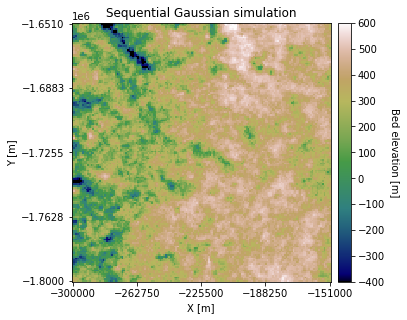

In [7]:
mplot1(Pred_grid_xy, sim_trans, rows, cols, title='Sequential Gaussian simulation', clabel='Bed elevation [m]')

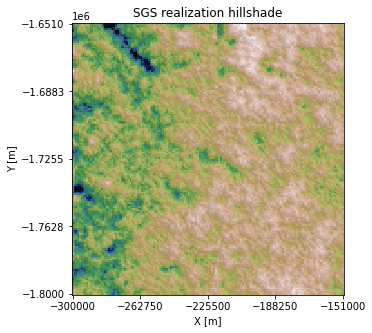

In [8]:
mplot1(Pred_grid_xy, sim_trans, rows, cols, title='SGS realization hillshade', hillshade=True)

SGS can be used to simulate multiple realizations for quantifying uncertainty. Let's generate a couple more realizations.

In [9]:
# simulate multiple random realizations

# simulation 2
sim2 = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 
sim2 = sim2.reshape(-1,1)
sim2_trans = nst_trans.inverse_transform(sim2)

# simulation 3
sim3 = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 
sim3 = sim3.reshape(-1,1)
sim3_trans = nst_trans.inverse_transform(sim3)

100%|████████████████████████████████████| 22500/22500 [02:49<00:00, 132.99it/s]


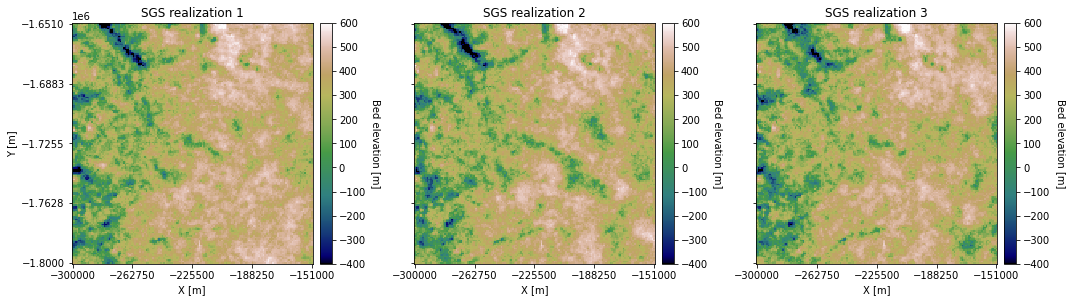

In [10]:
x_mat = Pred_grid_xy[:,0].reshape((rows, cols))
y_mat = Pred_grid_xy[:,1].reshape((rows, cols))

plots = [sim_trans, sim2_trans, sim3_trans]

fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

for i, (ax, plot) in enumerate(zip(axs, plots)):
    sgs_mat = plot.reshape((rows, cols))
    im = ax.pcolormesh(x_mat, y_mat, sgs_mat, vmin=-400, vmax=600, cmap='gist_earth')
    ax.set_title(f'SGS realization {i+1}')
    ax.set_xlabel('X [m]')
    if i == 0:
        ax.set_ylabel('Y [m]')
    ax.set_xticks(np.linspace(xmin, xmax, 5))
    ax.set_yticks(np.linspace(ymin, ymax, 5))

    cbar = make_colorbar(fig, im, -400, 600, 'Bed elevation [m]', ax=ax)
    ax.axis('scaled')
    
plt.tight_layout()
plt.show()

You can see that they all look a bit different from each other.

## SGS Roughness

The topography generated using SGS is much rougher than the kriging examples. Let's check the variograms to see if the roughness statistics of the data are reproduced.

In [11]:
# compute SGS variogram

# downsample random indices to speed this up
rand_indices = random.sample(range(np.shape(Pred_grid_xy)[0]),5000)

# get coordinates and normalized simulation from random indices
coords_s = Pred_grid_xy[rand_indices]
values_s = sim[rand_indices]

VS = skg.Variogram(coords_s, values_s, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

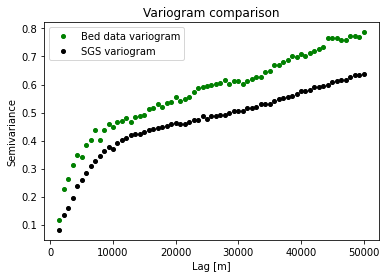

In [12]:
# experimental variogram (from beginning of script)
xe = V1.bins
ye = V1.experimental

# simple kriging variogram
xs = VS.bins
ys = VS.experimental

plt.figure(figsize=(6,4))
plt.plot(xe,ye,'og', markersize=4, label = 'Bed data variogram')
plt.plot(xs,ys,'ok', markersize=4, label = 'SGS variogram')
plt.title('Variogram comparison')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')
plt.legend(loc='upper left')
plt.show()

We can see that the variograms are very similar. This means that SGS is reproducing the spatial statistics of observations.

Download the tutorial {Download}`here<./4_Sequential_Gaussian_Simulation.ipynb>`.